# **Downloading the Dataset of Fingerprint based Blood grouping**

In [ ]:
!pip install opencv-python pandas matplotlib tensorflow keras

In [ ]:
from google.colab import userdata
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset
!unzip "finger-print-based-blood-group-dataset"

In [3]:
import os
data_path = '/content/dataset_blood_group'
os.listdir(path=data_path)

['A+', 'B+', 'A-', 'AB+', 'O-', 'B-', 'O+', 'AB-']

# **Checking if all images are in correct format**

In [4]:
import cv2
import imghdr

ext_set = set()
for group in os.listdir(path=data_path):
    for image in os.listdir(os.path.join(data_path, group)):
      path_now = os.path.join(data_path, group, image)
      try:
        img = cv2.imread(path_now)
        ext = imghdr.what(path_now)
        ext_set.add(ext)
      except Exception:
        os.remove(path_now)

print(f"You have {len(ext_set)} types of images in your dataset : {ext_set}")

You have 1 types of images in your dataset : {'bmp'}


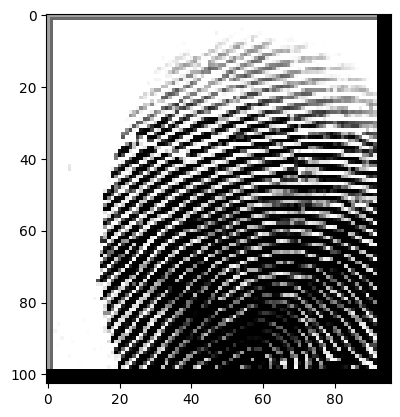

In [5]:
import matplotlib.pyplot as plt

an_image = '/content/dataset_blood_group/A+/cluster_0_1001.BMP'
img = cv2.imread(an_image)
plt.imshow(img, cmap="gray")

# **Loading the Dataset to process**



In [6]:
import tensorflow as tf
import numpy as np

dataset = tf.keras.utils.image_dataset_from_directory(data_path)
class_names = dataset.class_names

Found 6000 files belonging to 8 classes.


In [7]:
for i, class_name in enumerate(class_names):
    print(f"Class {i} corresponds to label '{class_name}'")

Class 0 corresponds to label 'A+'
Class 1 corresponds to label 'A-'
Class 2 corresponds to label 'AB+'
Class 3 corresponds to label 'AB-'
Class 4 corresponds to label 'B+'
Class 5 corresponds to label 'B-'
Class 6 corresponds to label 'O+'
Class 7 corresponds to label 'O-'


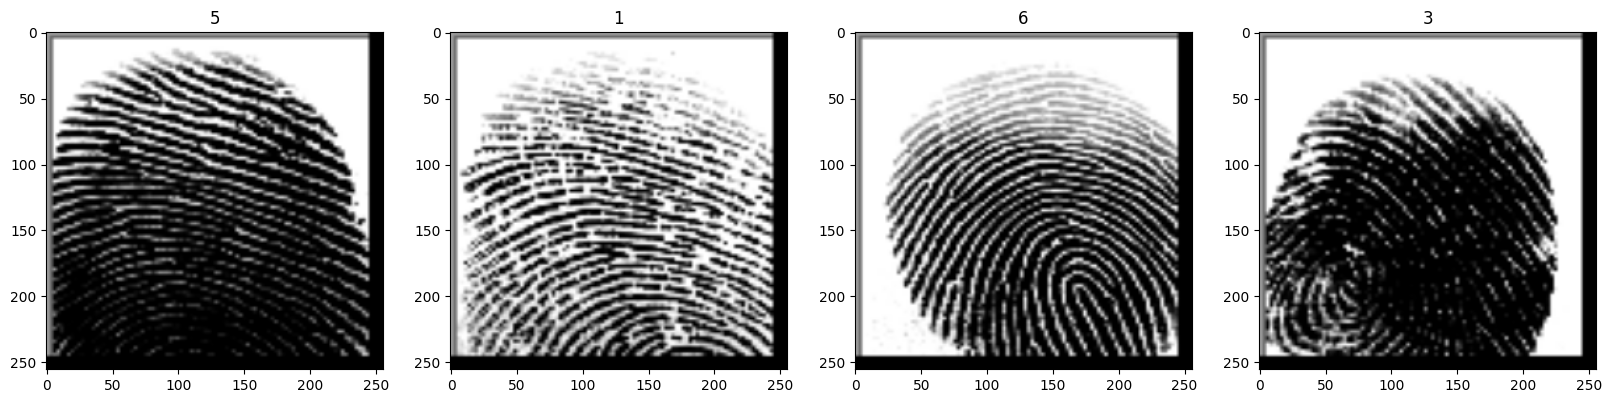

In [9]:
data = dataset.map(lambda x,y: (x/255, y))
batch = data.as_numpy_iterator().next()

figure, axis = plt.subplots(ncols=4, figsize=(20,20))
for id, array in enumerate(batch[0][:4]):
    axis[id].imshow(array)
    axis[id].title.set_text(batch[1][id])

# **Preprocessing images and splitting into train, test and validation**

In [10]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_images = []
train_labels = []
for x, y in train:
    train_images.extend(x.numpy())
    train_labels.extend(y.numpy())
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Training images shape:", train_images.shape)
train= train_datagen.flow(train_images, train_labels, batch_size=32)

val_images = []
val_labels = []
for x, y in val:
    val_images.extend(x.numpy())
    val_labels.extend(y.numpy())
val_images = np.array(val_images)
val_labels = np.array(val_labels)

print("Validation images shape:", val_images.shape)
val = ImageDataGenerator().flow(val_images, val_labels, batch_size=32)

test_images = []
test_labels = []
for x, y in test:
    test_images.extend(x.numpy())
    test_labels.extend(y.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Test images shape:", test_images.shape)
test= ImageDataGenerator().flow(test_images, test_labels, batch_size=32)


Training images shape: (4192, 256, 256, 3)


# **Creating the model**

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dense, Flatten, Dropout, BatchNormalization

model = Sequential()

model.add(Conv2D(16,(3,3),1, activation = 'relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3),1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3),1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(256, (3,3),1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3),1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile('adam', loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │              

 Total params: 1,078,888 (4.12 MB)

 Trainable params: 1,077,896 (4.11 MB)

 Non-trainable params: 992 (3.88 KB)

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
with tf.device('/device:GPU:0'):
  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
  mod = model.fit(train, epochs=50, validation_data=val, callbacks=[lr_scheduler])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 462ms/step - accuracy: 0.2484 - loss: 2.6110 - val_accuracy: 0.1149 - val_loss: 5.0092 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 443ms/step - accuracy: 0.4198 - loss: 1.4289 - val_accuracy: 0.1681 - val_loss: 3.9854 - learning_rate: 0.0010
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.5959 - loss: 1.0794 - val_accuracy: 0.2863 - val_loss: 2.6078 - learning_rate: 0.0010
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 442ms/step - accuracy: 0.6980 - loss: 0.7967 - val_accuracy: 0.6140 - val_loss: 1.1964 - learning_rate: 0.0010
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 452ms/step - accuracy: 0.7152 - loss: 0.7469 - val_accuracy: 0.6098 - val_loss: 2.4019 - learning_rate: 0.0010
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 429ms/step - accuracy: 0.7382 - loss: 0.6838 - val_accuracy: 0.5431 - val_loss: 1.5641 - learning_rate: 0.0010
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 441ms/step - accuracy: 0.7316 - loss:

# **Evaluation part**

In [24]:
loss, acc = model.evaluate(test, verbose=2)

131/131 - 54s - 412ms/step - accuracy: 0.8361 - loss: 0.4255


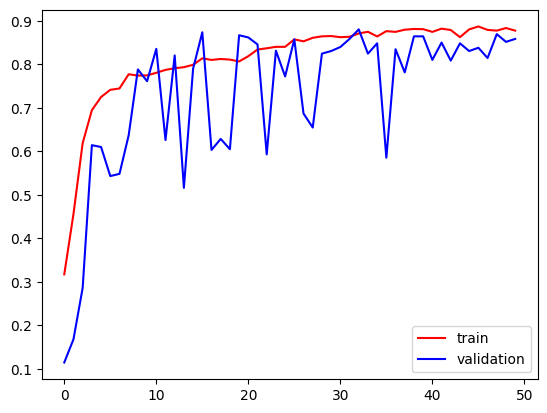

In [18]:
import matplotlib.pyplot as plt

plt.plot(mod.history['accuracy'],color='red',label='train')
plt.plot(mod.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

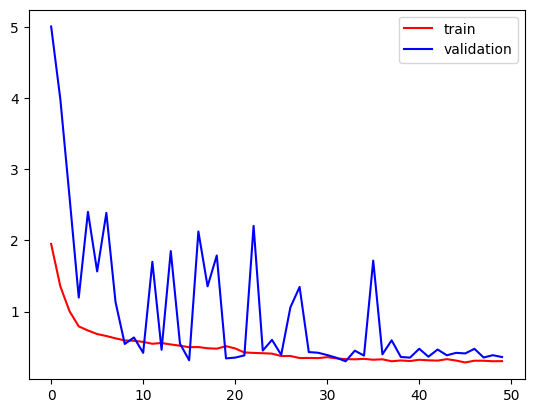

In [19]:
plt.plot(mod.history['loss'],color='red',label='train')
plt.plot(mod.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [22]:
model.save('/content/drive/MyDrive/Colab Notebooks/fingerprint86.h5')

In [20]:
imgpre = cv2.imread('/content/dataset_blood_group/B+/cluster_2_10.BMP')
resize = tf.image.resize(imgpre, (256,256))
prediction = model.predict(np.expand_dims(resize/255, 0))
prediction = np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [21]:
prediction

4